In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading dataset

In [42]:
%cd drive/MyDrive/NLP_Project/twitter_data/
!ls

[Errno 2] No such file or directory: 'drive/MyDrive/NLP_Project/twitter_data/'
/content/drive/MyDrive/NLP_Project/twitter_data
agr_en_fb_gold.csv  tc_a.csv  tc_b.csv	tw_fb_gold.csv	val.csv  val_d.csv


## Importing libraries

In [3]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
     |████████████████████████████████| 6.6 MB 36.6 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 342 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 10.0 MB/s 
     |████████████████████████████████| 212 kB 23.1 MB/s 
     |████████████████████████████████| 136 kB 22.6 MB/s 
     |████████████████████████████████| 127 kB 23.1 MB/s 
     |████████████████████████████████| 271 kB 23.4 MB/s 
     |████████████████████████████████| 144 kB 29.0 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ER

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

In [77]:
aggressions = load_dataset('csv', data_files={'train': 'tw_fb_gold.csv',
                                              'validation': 'tc_a.csv',
                                              'test': 'tc_b.csv'})
print(aggressions)

Using custom data configuration default-30176854d6e04557


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-30176854d6e04557/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Tweet', 'Category'],
        num_rows: 2105
    })
    validation: Dataset({
        features: ['Tweet', 'Category'],
        num_rows: 135
    })
    test: Dataset({
        features: ['Tweet', 'Category'],
        num_rows: 299
    })
})


In [44]:
train_ds = aggressions['train']
train_ds

Dataset({
    features: ['Tweet', 'Category'],
    num_rows: 2105
})

## Converting to dataframe

In [80]:
aggressions.set_format(type='pandas')
df = aggressions['train'][:]
df.head()

,Tweet,Category
0,If government of india don't take strict actio...,0
1,So now we know. The women should be under the ...,0
2,गद्दारो तुमसे ही तो खतरा है अबकी बार साफ हो जाओगे,0
3,Do you think markets are gonna be sideways til...,0
4,Jago Urjut Jago....\nSave common people from\n...,0


In [81]:
df['Category'].value_counts()

1    712
0    701
2    692
Name: Category, dtype: int64

In [82]:
dt = {0:'NAG', 1:'CAG', 2:'OAG'}
df['Category'].unique()
labels = map(lambda x: dt[x], df['Category'])
labels = list(labels)
labels = pd.Series(labels)

df['Category_Name'] = labels
labs = np.array(labels)
df.head(5)

,Tweet,Category,Category_Name
0,If government of india don't take strict actio...,0,NAG
1,So now we know. The women should be under the ...,0,NAG
2,गद्दारो तुमसे ही तो खतरा है अबकी बार साफ हो जाओगे,0,NAG
3,Do you think markets are gonna be sideways til...,0,NAG
4,Jago Urjut Jago....\nSave common people from\n...,0,NAG


Seeing Distribution

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


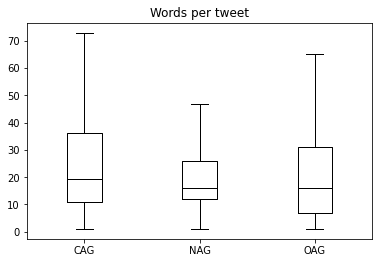

In [83]:
df['Words per tweet'] = df['Tweet'].str.split().apply(len)
df.boxplot('Words per tweet', by='Category_Name', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## Tokenizing

In [49]:
from transformers import AutoTokenizer

In [66]:

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [13]:
tokenizer.vocab_size

30522

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
# df_val = df_val[df_val['Category'].notna()]
# val_labs = map(lambda x : int(x), df_val['Category'])
# val_labs = list(val_labs)
# df_val['Int_Category'] = pd.Series(val_labs)

texts = list(df['Tweet'])
# val_texts = list(df_val['Tweet'])
labels = list(df['Category'])
# val_labels = list(df_val['Category'])


In [93]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
     texts, labels, test_size=0.2, random_state=42)

In [94]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [95]:
import torch

class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [96]:
train_dataset = TwitterDataset(train_encodings, train_labels)
val_dataset = TwitterDataset(val_encodings, val_labels)

In [97]:
# Tokenizing batch input
def tokenize(batch):
  bt = list(batch['Tweet'])
  return tokenizer(bt, padding=True, truncation=True)

In [98]:
# Checking first two rows of our dataset
print(tokenize(aggressions['train'][:2]))

{'input_ids': [[101, 2065, 2231, 1997, 2634, 2123, 1005, 1056, 2202, 9384, 2895, 2114, 2859, 2059, 2574, 2634, 2097, 2022, 2006, 1996, 8840, 18606, 2217, 2469, 102, 0, 0, 0, 0], [101, 2061, 2085, 2057, 2113, 1012, 1996, 2308, 2323, 2022, 2104, 1996, 15562, 1012, 2138, 1037, 12873, 2406, 2003, 2081, 2000, 2228, 2008, 2009, 1005, 1055, 4658, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [99]:
# Encoding whole batch
aggressions_encoded = aggressions.map(tokenize, batched=True, batch_size=None)
print(aggressions_encoded['train'].column_names)

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-30176854d6e04557/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-ca43428460846b62.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-30176854d6e04557/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-79716c79a06d9287.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-30176854d6e04557/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-482dd0f41a3a0e3a.arrow


['Tweet', 'Category', 'input_ids', 'attention_mask']


## Fine-tuning

In [100]:
import torch

In [101]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [102]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if 
                      torch.cuda.is_available() else 'cpu')
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

In [103]:
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix

In [104]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1':f1}

In [105]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [106]:
from transformers import Trainer, TrainingArguments

In [107]:
# Defining hyperparameters
batch_size = 16
logging_steps = len(aggressions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-aggression"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=1.5e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='error')

In [108]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [109]:
trainer = Trainer(model=model, args=training_args,
compute_metrics = compute_metrics,
train_dataset = train_dataset,
eval_dataset = val_dataset,
tokenizer = tokenizer)

trainer.train()


/content/drive/MyDrive/NLP_Project/twitter_data/distilbert-base-uncased-finetuned-aggression is already a clone of https://huggingface.co/SkyR/distilbert-base-uncased-finetuned-aggression. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.833495,0.653207,0.650655
2,0.952100,0.765333,0.679335,0.680793
3,0.693000,0.731902,0.693587,0.696759
4,0.564400,0.735776,0.695962,0.700087
5,0.469900,0.748087,0.695962,0.702159


TrainOutput(global_step=530, training_loss=0.6669716641588032, metrics={'train_runtime': 1025.869, 'train_samples_per_second': 8.208, 'train_steps_per_second': 0.517, 'total_flos': 1115395387822080.0, 'train_loss': 0.6669716641588032, 'epoch': 5.0})

## Predictions

In [135]:
before_tweets = pd.read_csv('tc_b.csv')
after_tweets = pd.read_csv('tc_a.csv')

In [136]:
before_labels = list(before_tweets['Category'])
before_texts = list(before_tweets['Tweet'])

after_labels = list(after_tweets['Category'])
after_texts = list(after_tweets['Tweet'])

In [137]:
before_encodings = tokenizer(before_texts, truncation=True, padding=True)
after_encodings = tokenizer(after_texts, truncation=True, padding=True)

In [138]:
before_dataset = TwitterDataset(before_encodings, before_labels)
after_dataset = TwitterDataset(after_encodings, after_labels)

In [139]:
preds_output_before = trainer.predict(before_dataset)
preds_output_after = trainer.predict(after_dataset)

In [140]:
preds_output_before.metrics

{'test_accuracy': 0.5518394648829431,
 'test_f1': 0.555514045072083,
 'test_loss': 1.0707790851593018,
 'test_runtime': 3.575,
 'test_samples_per_second': 83.637,
 'test_steps_per_second': 5.315}

In [141]:
preds_output_after.metrics

{'test_accuracy': 0.674074074074074,
 'test_f1': 0.6494190583079471,
 'test_loss': 0.8110001087188721,
 'test_runtime': 1.015,
 'test_samples_per_second': 133.002,
 'test_steps_per_second': 8.867}

In [152]:
y_preds_before = np.argmax(preds_output_before.predictions, axis=1)

In [153]:
y_preds_after = np.argmax(preds_output_after.predictions, axis=1)

In [154]:
y_valid_before = np.array(before_dataset.labels)
y_valid_after = np.array(after_dataset.labels)

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_before = map(lambda x : dt[x], y_valid_before)
y_valid_before = list(y_valid_before)

y_preds_before = map(lambda x : dt[x], y_preds_before)
y_preds_before = list(y_preds_before)

cm = confusion_matrix(y_valid_before, y_preds_before)

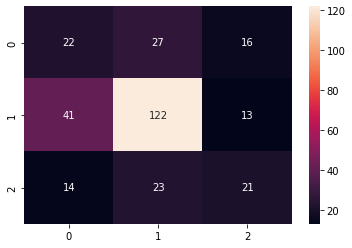

In [156]:
f = sns.heatmap(cm, annot=True, fmt='d')

In [157]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_after = map(lambda x : dt[x], y_valid_after)
y_valid_after = list(y_valid_after)

y_preds_after = map(lambda x : dt[x], y_preds_after)
y_preds_after = list(y_preds_after)

cm = confusion_matrix(y_valid_after, y_preds_after)

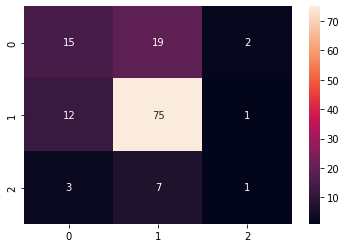

In [158]:
f = sns.heatmap(cm, annot=True, fmt='d')

In [160]:
before_dt = {'NAG':0, 'CAG':0, 'OAG':0}
after_dt = {'NAG':0, 'CAG':0, 'OAG':0}

for l in y_preds_before:
  before_dt[l] += 1

for l in y_preds_after:
  after_dt[l] += 1

print('Before election tweet predictions')
print(before_dt)

print('After election tweet predictions')
print(after_dt)

Before election tweet predictions
{'NAG': 172, 'CAG': 77, 'OAG': 50}
After election tweet predictions
{'NAG': 101, 'CAG': 30, 'OAG': 4}
